## F21DL - MACHINE LEARNING PORTFOLIO

#### MIT DATASET FOR IDENTIFYING PLACES USING COMPUTER VISION

##### Rucha Tare
##### Maxime Mavel
##### Daniel Eneh
##### Aureline Lohmann

### STEP 1 : SOURCING DATA
We chose <code><strong>MIT places Dataset</strong></code> from the following options below:
- 1. Bird species classification - BIRDS 400 - SPECIES IMAGE CLASSIFICATION | Kaggle [Data set Link](https://www.kaggle.com/datasets/akash2907/bird-species-classification)

Source: Kaggle

Data Description: Data helps to predict bird species with help of images and attributes tagged to images. Data has species of 400 birds and number of images for each species. It also has attributes like height, weight of the image used, name of the bird and class of the bird species. The data is already divided into test and train folders. It has 400 instances

- 2. Australian Sign Language: UCI Machine Learning Repository: Australian Sign Language signs Data Set [Dataset Link](https://archive.ics.uci.edu/ml/datasets/Australian+Sign+Language+signs)

Source: UCL Machine Learning Repository

Data description: Data has x,y,z coordinate measurements of a Nintendo Glove that helps to predict that Australian Sign Language. The data has 15 attributes related to positions of the co-ordinate and images with 6650 instances

- 3. Movie Genre prediction from its posters: Movie Genre from its Poster | Kaggle [Dataset Link](https://www.kaggle.com/code/krutarthhd/genre-prediction-from-the-movie-poster/data)

Source - Kaggle

Description of the data: This dataset has images of the movie posters and movie attributes like IMDB ID, IMDB link, Genre, Ranking. It has 998 instances.

Pros:

Has combination of images and attributes
Since we have a lot of movie posters on internet, we can tweak data sets to add more instances if needed or manipulate the data
We can test the model on newer poster every time so that it actually predicts accurate results as compared to above bird or sign languages.
Attributes have link, text,number, floats to play around with

- 4. MIT places Mini dataset: We later found this MIT places mini dataset which is a great places dataset originally created by MIT AI researchers. It has 100,000 images labelled. We have taken subset of it not all the dataset hence it is called <b>mini MIT places</b>

[MIT Places Dataset Link](http://dl.caffe.berkeleyvision.org/mit_mini_places/)

Source : Google

<b>Pros of this dataset</b> :

- 1. More number of instances
- 2. Credible datasets by MIT researchers
- 3. More number of features will help us learn and explore more
- 4. Versatile dataset that can be played around with many applications and things are it identifying places and scenes

<b>Cons with First three datasets</b>:

- 1. Creating new data will be troublesome as we don't have images and attributes.

- 2. Australian sign language attributes are just coordinates so it is not much to play around with, similar to the bird dataset that mostly has numbers and two text columns

- 3. Movie was a great dataset but number of instances were 998 only.

_Conclusion: Due to above cons we decided to choose the MIT places dataset_

<b>The Group Gitlab REPOSITORY is seen</b> : <code>[HERE](https://gitlab-student.macs.hw.ac.uk/rt2026/ml-portoflio-mit-places)</code>



### 1.1 - Importing Relevant Libraries and data options

In [1]:
!pip install tensorflow==2.3.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# ignore warnings
import warnings

# importing needed libraries to python
import pandas as pd
import os
import re
import numpy as np

# visualisations
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from collections import Counter

# import openCV
import cv2

# sklearn imports
from sklearn import preprocessing
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                     cross_val_predict, cross_validate, 
                                     RandomizedSearchCV)

from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.linear_model import SGDClassifier, LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (accuracy_score, f1_score, 
                             recall_score, precision_score, 
                             confusion_matrix, mean_squared_error)

# keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
warnings.filterwarnings('ignore')

### Configurations

In [3]:
category_dir = 'drive/MyDrive/Colab Notebooks/labels/'
image_dir = 'drive/MyDrive/Colab Notebooks/images'

In [4]:
categories_txt = 'categories.txt'
train_txt= 'train.txt'
val_txt= 'val.txt'
path_train= category_dir + train_txt
path_val = category_dir + val_txt 

### Data Loading and Data Preprocessing

Data Description: categories.txt - 0-99 categories

train.txt - training dataset to categorise images

training data images- 100,000 Images for all the 0-99 categories

### Creating Category Dataset

In [5]:
categories_file = open(f'{category_dir}{categories_txt}', 'r') 
category_records = categories_file.readlines()
categories_file.close()

We are creating a dictionary for category that will have category id and category record so that we can later verify the category name with the id. Since few categories also have sub categories in them e.g / i / ice_skating_rink / outdoor 56 we are replacing "/" to "-". So that we get the prediction as ice_skating_rink - outdoor

In [6]:
categories_dataset = {}
for category_record in category_records:
    category_name, category_id = category_record.split(" ")
    category_name = category_name[3:].replace('/','-')
    categories_dataset[int(category_id)] = category_name

### Image Processing

In [7]:
# verifying the image path
print(f'{image_dir}/train/a/abbey/00000001.jpg')

drive/MyDrive/Colab Notebooks/images/train/a/abbey/00000001.jpg


In [8]:
# reading a test image for two reasons: 1. Checking the image 2. Using the image to take 80% of its dimensions to scale 
test_image = cv2.imread(f'{image_dir}/train/a/abbey/00000001.jpg', cv2.IMREAD_COLOR)

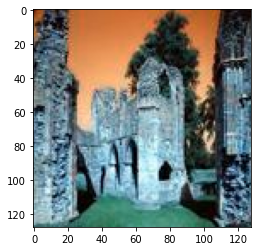

In [9]:
# verifying the image plot for test image
plt.imshow(test_image)
plt.show()

In [10]:
# getting the 25% size for image for further preprocessing
SCALE_PERCENT = 80
WIDTH = int(test_image.shape[1] * SCALE_PERCENT / 100)
HEIGHT = int(test_image.shape[0] * SCALE_PERCENT / 100)
DIM = (WIDTH, HEIGHT)

# printing the scaled size of the test image. We will use these dimensions in the below function while scaling train and val images
print("Scaled image size should be: ", DIM)

Scaled image size should be:  (102, 102)


In [11]:
def image_resize(image):
    """ Function to define resizing images. This will be called from image_preprocess
    Args: 
        image list: list of images
    returns:
        image_rs list: list of images resized 
    """
    image_rs = cv2.resize(image, DIM, interpolation=cv2.INTER_AREA)

    return image_rs        

In [12]:
def image_to_array(images):
    """ Defining function to convert images to array
    Args:
        images: list of images
    returns:
        images_arr_rs: array of reshaped images
    """
    # Data Normalization
    images = np.array(images)
    images = images.astype('float32') 
    # Normalization
    images = images/255.0
    images_arr_rs = images.reshape((len(images), -1))

    return images_arr_rs

In [13]:
def preprocess_image(image_dir, category_path):
    """ Defining a function to read, resize images and categories
    Args:
        image_dir: image_dir to read images from
        category_path: category path to read categories
    """
    images = []
    image_paths = []
    categories = []
    file = open(category_path, 'r') 
    label_records = file.readlines()
    file.close()

    for record in label_records:
        # split each line on label file using spaces into image path and category id
        image_path, category = record.split(" ")  

        # load images and resize
        image_w = cv2.imread(f'{image_dir}/{image_path}', cv2.IMREAD_COLOR)
        image_bw = cv2.cvtColor(image_w, cv2.COLOR_BGR2GRAY)
        image_bw = image_resize(image_bw)
        
        # load filenames as a list
        image_paths.append(f'{image_dir}/{image_path}')

        # adding image and category to the list
        images.append(image_bw)
        categories.append(int(category))
        
    return images, categories, image_paths

abbey


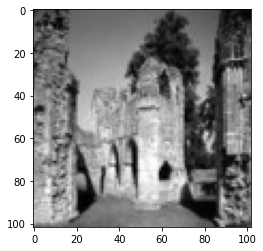

In [14]:
# getting train dataset by calling preprocess and plotting a train image and verifying its category
images_train, category_train, image_paths_train = preprocess_image(image_dir, path_train)
print(categories_dataset[category_train[0]])
plt.imshow(images_train[0], cmap='gray')
plt.show()

palace


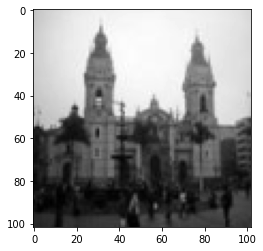

In [15]:
# getting validation dataset by calling preprocess and plotting a val image and verifying its category
images_val, category_val, image_paths_val = preprocess_image(image_dir, path_val)
print(categories_dataset[category_val[0]])
plt.imshow(images_val[0], cmap='gray')
plt.show()

In [16]:
# calling images to array and getting X train, Y train, X val , Y val
X = image_to_array(images_train)
y = pd.DataFrame(category_train, columns=['category'])
X_val = image_to_array(images_val)
y_val = pd.DataFrame(category_val, columns=['category'])

In [17]:
X_train, X_train_inventory, y_train, y_train_inventory = train_test_split(X, y, test_size=0.70, random_state=42, stratify=y)

In [18]:
X_val, X_val_inventory, y_val, y_val_inventory = train_test_split(X_val, y_val, test_size=0.60, random_state=42, stratify=y_val)

In [19]:
print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)
print("X_val Shape: ", X_val.shape)
print("y_val Shape: ", y_val.shape)

X_train Shape:  (30000, 10404)
y_train Shape:  (30000, 1)
X_val Shape:  (4000, 10404)
y_val Shape:  (4000, 1)


### Getting the datasets for Neural Networks training

In [ ]:
# getting train dataset by calling preprocess and plotting a train image and verifying its category for Neural Networks
# change the image size in the above cell to increase the size
images_train_NN, category_train_NN, image_paths_train_NN = preprocess_image(image_dir, path_train)
print(categories_dataset[category_train_NN[0]])
plt.imshow(images_train_NN[0], cmap='gray')
plt.show()

In [ ]:
images_val_NN, category_val_NN, image_paths_val_NN = preprocess_image(image_dir, path_val)
print(categories_dataset[category_val_NN[0]])
plt.imshow(images_val_NN[0], cmap='gray')
plt.show()

In [ ]:
# calling images to array and getting X train, Y train, X val , Y val
X_nn = image_to_array(images_train_NN)
y_nn = pd.DataFrame(category_train_NN, columns=['category'])

In [ ]:
X_test_nn = image_to_array(images_val_NN)
y_test_nn = pd.DataFrame(category_val_NN, columns=['category'])

In [ ]:
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_nn, y_nn, test_size=0.10, random_state=42, stratify=y_nn)

In [ ]:
print("X_train Shape: ", X_train_nn.shape)
print("y_train Shape: ", y_train_nn.shape)
print("X_val Shape: ", X_test_nn.shape)
print("y_val Shape: ", y_test_nn.shape)

### Model Monitoring Helper Functions

In [ ]:
def get_cross_validation(model, X, y, scoring, cv=10):
    """ Function to get the cross validation for model
    Args:
        model:
        X_train:
        y_train:
        cv:
    """
    cross_validation_results = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    
    return cross_validation_results

In [ ]:
# graph representation
def plot_histogram(x, bins=10, title="Histogram"):
    """ Provides graph to display cluster and its counts
    """
    plt.hist(x, bins=bins)
    plt.title(title)
    return plt.show

    
def plot_cv_results(cv_results, param_x, param_hue, metric='mean_test_score'):
    """ Plotting the graph for two parameters from Random Search CV
    """
    cv_results = pd.DataFrame(cv_results)
    col_x = 'param_' + param_x
    col_hue = 'param_' + param_hue
    
    fig, ax = plt.subplots(1, 1, figsize=(11, 8))
    sns.pointplot(x=col_x, y=metric, hue=col_hue, data=cv_results, ci=99, n_boot=64, ax=ax)
    
    ax.set_title("CV Random Search Results")
    ax.set_xlabel(param_x)
    ax.set_ylabel(metric)
    ax.legend(title=param_hue)
    
    return fig

In [ ]:
def get_model_report(y_true, y_pred):
    """ Provides a model performance report 
    """
    model_accuracy = accuracy_score(y_true, y_pred)
    model_f1_score = f1_score(y_true, y_pred, average='weighted')
    model_precision = precision_score(y_true, y_pred, average='weighted')
    model_recall = recall_score(y_true, y_pred, average='weighted')
    
    print(f"Model Accuracy: {round(model_accuracy, 3)}")
    print(f"Model F1 Score: {round(model_f1_score, 3)}")
    print(f"Model Precision: {round(model_precision, 3)}")
    print(f"Model Recall: {round(model_recall, 3)}")
    
    return model_accuracy

In [ ]:
models_summary = pd.DataFrame(columns = ['Model Name', 
                                         'Train Accuracy', 
                                         'Test Accuracy',
                                        ])
def add_to_model_summary(models_summary, model_name, train_acc, test_acc):
    """ Adding model performance summary to compare models
    """
    models_summary = models_summary.append({'Model Name': model_name, 
                           'Train Accuracy': train_acc, 
                           'Test Accuracy': test_acc}, ignore_index=True)
    return models_summary

### Modelling
### Classification

In [ ]:
sgd_clf = SGDClassifier(max_iter=10, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train)

In [ ]:
get_cross_validation(sgd_clf, X_train, y_train, scoring="accuracy", cv=5)

In [ ]:
y_pred_train_sgd_clf = sgd_clf.predict(X_train)
y_pred_test_sgd_clf = sgd_clf.predict(X_val)

In [ ]:
model_sgd_train_accuracy = get_model_report(y_train, y_pred_train_sgd_clf)
model_sgd_test_accuracy = get_model_report(y_val, y_pred_test_sgd_clf)
models_summary = add_to_model_summary(models_summary, 'SGD Classifier', model_sgd_train_accuracy, model_sgd_test_accuracy)

### Multinomial NB

In [ ]:
model_MNB = MultinomialNB()
model_MNB.fit(X_train, y_train)

In [ ]:
model_MNB.predict(X_val)

In [ ]:
cross_val_score(model_MNB, X_train, y_train, cv=3, scoring="accuracy") 

In [ ]:
y_pred_MNB = cross_val_predict(model_MNB, X_val, y_val, cv=3)
confusion_matrix(y_val, y_pred_MNB)

In [ ]:
y_pred_train_model_MNB = model_MNB.predict(X_train)
y_pred_test_model_MNB = model_MNB.predict(X_val)

In [ ]:
model_MNB_train_accuracy = get_model_report(y_train, y_pred_train_model_MNB)
model_MNB_test_accuracy = get_model_report(y_val, y_pred_test_model_MNB)
models_summary = add_to_model_summary(models_summary, 'Multinomial NB', model_MNB_train_accuracy, model_MNB_test_accuracy)

### Gaussian NB

In [ ]:
model_GNB = GaussianNB()
model_GNB.fit(X_train, y_train)

In [ ]:
cross_val_score(model_GNB, X_train, y_train, cv=3, scoring="accuracy")

In [ ]:
y_pred_GNB = cross_val_predict(model_GNB, X_val, y_val, cv=3)
confusion_matrix(y_val, y_pred_GNB)

In [ ]:
y_pred_train_model_GNB = model_GNB.predict(X_train)
y_pred_test_model_GNB = model_GNB.predict(X_val)

In [ ]:
model_GNB_train_accuracy = get_model_report(y_train, y_pred_train_model_GNB)
model_GNB_test_accuracy = get_model_report(y_val, y_pred_test_model_GNB)
models_summary = add_to_model_summary(models_summary, 'Gaussian NB', model_GNB_train_accuracy, model_GNB_test_accuracy)

### Complement NB

In [ ]:
model_CNB = ComplementNB()
model_CNB.fit(X_train, y_train)

In [ ]:
cross_val_score(model_CNB, X_train, y_train, cv=3, scoring="accuracy")

In [ ]:
y_pred_train_model_CNB = model_CNB.predict(X_train)
y_pred_test_model_CNB = model_CNB.predict(X_val)

In [ ]:
model_CNB_train_accuracy = get_model_report(y_train, y_pred_train_model_CNB)
model_CNB_test_accuracy = get_model_report(y_val, y_pred_test_model_CNB)
models_summary = add_to_model_summary(models_summary, 'Complement NB', model_CNB_train_accuracy, model_CNB_test_accuracy)

### Clustering

In [ ]:
total_clusters = len(np.unique(y_train))

In [ ]:
def get_reference_labels(cluster_labels, y, total_clusters):
    """
    """
    # Initializing
    refer_labels = {}
    
    # loop through each label of cluster
    for i in range(total_clusters):
        index = np.where(cluster_labels == i, 1, 0)
        num = np.bincount(y[[index == 1]]).argmax()
        refer_labels[i] = num
    
    return refer_labels

### Gaussian Mixture

In [ ]:
# Initialize the Gaussian Mixture model
model_GM = GaussianMixture(n_components=10, random_state=42)

# Fitting the model to training set
model_GM.fit(X_train)

# get the weights of each mixture component
model_GM_weights = model_GM.weights_

In [ ]:
# Initialize the K-Means model
mini_kmeans = MiniBatchKMeans(n_clusters = total_clusters, random_state=42)

# Fitting the model to training set
mini_kmeans.fit(X_train)

# get the cluster labels
mini_kmeans_labels = mini_kmeans.labels_

In [ ]:
y_train_kmeans = y_train["category"].to_numpy()

In [ ]:
reference_labels = get_reference_labels(mini_kmeans_labels, y_train_kmeans, total_clusters)

# defining a dummy list of predicted labels
predicted_labels = np.random.rand(len(mini_kmeans_labels))

for i in range(len(mini_kmeans.labels_)):
    predicted_labels[i] = reference_labels[mini_kmeans_labels[i]]

In [ ]:
print(accuracy_score(predicted_labels, y_train_kmeans))

In [ ]:
print(predicted_labels[:20].astype('int'))
print(y_train_kmeans[:20])

In [ ]:
centroids = mini_kmeans.cluster_centers_
centroids.shape

In [ ]:
centroids = centroids.reshape(100, 32, 32)
centroids = centroids * 255

In [ ]:
plt.figure(figsize = (10,9))
bottom = 0.35
for i in range(16):
    plt.subplots_adjust(bottom)
    plt.subplot(4, 4, i+1)
    plt.title(categories_dataset[reference_labels[i]], fontsize = 10)
    plt.imshow(centroids[i], cmap='gray')

In [ ]:
y_pred = mini_kmeans.predict(X_val)

In [ ]:
fig = plot_histogram(list(y_pred), bins=total_clusters, title="Cluster Membership Counts")

In [ ]:
counts = Counter(list(y_pred))
counts.most_common()[0]

In [ ]:
y_pred_train_mini_kmeans = mini_kmeans.predict(X_train)
y_pred_test_mini_kmeans = mini_kmeans.predict(X_val)

In [ ]:
mini_kmeans_train_accuracy = get_model_report(y_train, y_pred_train_mini_kmeans)
mini_kmeans_test_accuracy = get_model_report(y_val, y_pred_test_mini_kmeans)
models_summary = add_to_model_summary(models_summary, 'Mini KMeans', mini_kmeans_train_accuracy, mini_kmeans_test_accuracy)

### Kmeans Clustering Algorithm

In [ ]:
# Initialize the K-Means model
kmeans = KMeans(n_clusters = total_clusters, random_state=42)

# Fitting the model to training set
kmeans.fit(X_train)

# get the cluster labels
kmeans_labels = mini_kmeans.labels_

In [ ]:
y_train_kmeans = y_train["category"].to_numpy()

In [ ]:
reference_labels = get_reference_labels(kmeans_labels, y_train_kmeans, total_clusters)

# defining a dummy list of predicted labels
predicted_labels = np.random.rand(len(kmeans_labels))

for i in range(len(mini_kmeans.labels_)):
    predicted_labels[i] = reference_labels[kmeans_labels[i]]

In [ ]:
print(accuracy_score(predicted_labels, y_train_kmeans))

In [ ]:
print(predicted_labels[:20].astype('int'))
print(y_train_kmeans[:20])

In [ ]:
centroids = kmeans.cluster_centers_
centroids.shape

In [ ]:
centroids = centroids.reshape(100, 32, 32)
centroids = centroids * 255

In [ ]:
plt.figure(figsize = (10,9))
bottom = 0.35
for i in range(16):
    plt.subplots_adjust(bottom)
    plt.subplot(4, 4, i+1)
    plt.title(categories_dataset[reference_labels[i]], fontsize = 10)
    plt.imshow(centroids[i], cmap='gray')

In [ ]:
y_pred = kmeans.predict(X_val)

In [ ]:
fig = plot_histogram(list(y_pred), bins=total_clusters, title="Cluster Membership Counts")

In [ ]:
counts = Counter(list(y_pred))
counts.most_common()[0]

In [ ]:
y_pred_train_kmeans = kmeans.predict(X_train)
y_pred_test_kmeans = kmeans.predict(X_val)

In [ ]:
kmeans_train_accuracy = get_model_report(y_train, y_pred_train_kmeans)
kmeans_test_accuracy = get_model_report(y_val, y_pred_test_kmeans)
models_summary = add_to_model_summary(models_summary, 'KMeans', kmeans_train_accuracy, kmeans_test_accuracy)

### Decision Trees

In [ ]:
model_DecisionTree = DecisionTreeClassifier()
model_DecisionTree.fit(X_train, y_train)

In [ ]:
cross_validation_accuracy_results = get_cross_validation(model_DecisionTree, X_train, y_train, 'accuracy', cv=10)

In [ ]:
print("Accuracy Scores across KFolds: ", cross_validation_accuracy_results)
print("Accuracy for Decision Tree: ", cross_validation_accuracy_results.mean())

In [ ]:
params = {
            'max_depth': [2, 3, 5, 10, 20],
            'min_samples_leaf': [5, 10, 20, 50, 100],
            'max_leaf_nodes': [10, 30, 50, 100, 120],
            'criterion': ['gini', 'entropy'],
            'max_features': ['sqrt', 'log2']
        }

In [ ]:
random_search = RandomizedSearchCV(estimator=model_DecisionTree, 
                                   param_distributions=params, 
                                   cv=5, 
                                   n_jobs=-1,
                                   n_iter=30,
                                   verbose=1, 
                                   scoring = 'accuracy',
                                   return_train_score = True)

random_search.fit(X_train, y_train)

In [ ]:
random_search_results_df = pd.DataFrame(random_search.cv_results_)
print("Combinations tried using Random Search CV: ", random_search_results_df.shape[0])

In [ ]:
random_search_results_df.head(10)

In [ ]:
fig = plot_cv_results(random_search_results_df, 'max_depth', 'criterion')

In [ ]:
print("Best parameters for the Decision Tree based on Random Search CV: \n", random_search.best_params_)

In [ ]:
print("Best Score for the Decision Tree based on Random Search CV:", random_search.best_score_)

### Trying with best parameters obtained from Random Search CV

In [ ]:
model_DecisionTree_best_params = DecisionTreeClassifier(min_samples_leaf=100, 
                                            max_leaf_nodes=100, 
                                            max_features='log2', 
                                            max_depth=20, 
                                            criterion='entropy')

In [ ]:
# Training with 70% dataset
model_DecisionTree_best_params.fit(X_train_inventory, y_train_inventory)

In [ ]:
y_pred_train_decision_tree = model_DecisionTree_best_params.predict(X_train)
y_pred_test_decision_tree = model_DecisionTree_best_params.predict(X_val)

In [ ]:
decision_tree_train_accuracy = get_model_report(y_train, y_pred_train_decision_tree)
decision_tree_test_accuracy = get_model_report(y_val, y_pred_test_decision_tree)
models_summary = add_to_model_summary(models_summary, 'Decision Tree', decision_tree_train_accuracy, decision_tree_test_accuracy

### Linear Regression

In [ ]:
model_linearRegression = LinearRegression()
model_linearRegression.fit(X_train, y_train)
model_linearRegression.score(X_train, y_train)

### Trying our combinations of parameters

In [ ]:
model_linearRegression_1 = LinearRegression(fit_intercept=False,
                                          n_jobs=-1,
                                          positive=True)
model_linearRegression_1.fit(X_train, y_train)
model_linearRegression_1.score(X_train, y_train)

In [ ]:
model_linearRegression_2 = LinearRegression(fit_intercept=False,
                                          n_jobs=-1,
                                          positive=False)
model_linearRegression_2.fit(X_train, y_train)
model_linearRegression_2.score(X_train, y_train)

In [ ]:
model_linearRegression_3 = LinearRegression(fit_intercept=True,
                                          n_jobs=-1,
                                          positive=True)
model_linearRegression_3.fit(X_train, y_train)
model_linearRegression_3.score(X_train, y_train)

In [ ]:
# Going ahead with first combination of parameters used for model
model_linearRegression.get_params()

In [ ]:
y_train_pred_linearRegression = model_linearRegression.predict(X_train)

In [ ]:
y_test_pred_linearRegression = model_linearRegression.predict(X_val)

### Mean Squared and Root Mean Squared Error for train and test

In [ ]:
LR_MSE_train = mean_squared_error(y_train, y_train_pred_linearRegression, squared = True)
LR_MSE_train

In [ ]:
LR_RMSE_train = mean_squared_error(y_train, y_train_pred_linearRegression, squared = False)
LR_RMSE_train

In [ ]:
LR_MSE_test = mean_squared_error(y_val, y_test_pred_linearRegression, squared = True)
LR_MSE_test


In [ ]:
LR_RMSE_test = mean_squared_error(y_val, y_test_pred_linearRegression, squared = False)
LR_RMSE_test

### Logistic Regression

In [ ]:
model_logisticRegression = LogisticRegression()
model_logisticRegression.fit(X_train, y_train)

In [ ]:
model_logisticRegression.get_params()

In [ ]:
y_train_pred_logisticRegression = model_logisticRegression.predict(X_train)

In [ ]:
y_test_pred_logistic_Regression = model_logisticRegression.predict(X_val)

In [ ]:
LG_MSE_test = mean_squared_error(y_val, y_test_pred_logistic_Regression, squared = True)
LG_MSE_test

In [ ]:
LG_RMSE_test = mean_squared_error(y_val, y_test_pred_logistic_Regression, squared = False)
LG_RMSE_test

In [ ]:
print(confusion_matrix(y_val, y_test_pred_logistic_Regression))
print("Logistic Regression accuracy ", accuracy_score(y_val, y_test_pred_logistic_Regression))
#logistic_regression_confusion

### Trying manual combination of hyperparameters

In [ ]:
model_logisticRegression_1 = LogisticRegression(penalty='l2',
                                                C=0.1,
                                                class_weight='balanced',
                                                solver='newton-cg'
                                                )
model_logisticRegression_1.fit(X_train, y_train)
y_train_pred_logisticRegression_1 = model_logisticRegression_1.predict(X_train)
get_model_report(y_train, y_train_pred_logisticRegression_1)

In [ ]:
model_logisticRegression_2 = LogisticRegression(penalty='l2',
                                                C=0.01,
                                                class_weight='balanced',
                                                solver='newton-cg',
                                                tol=1e-2
                                                )
model_logisticRegression_2.fit(X_train, y_train)
y_train_pred_logisticRegression_2 = model_logisticRegression_2.predict(X_train)
get_model_report(y_train, y_train_pred_logisticRegression_2)

In [ ]:
model_logisticRegression_3 = LogisticRegression(penalty='l2',
                                                C=0.0001,
                                                class_weight='balanced',
                                                solver='newton-cg'
                                                )
model_logisticRegression_3.fit(X_train, y_train)
y_train_pred_logisticRegression_3 = model_logisticRegression_3.predict(X_train)
get_model_report(y_train, y_train_pred_logisticRegression_3)

In [ ]:
model_logisticRegression_4 = LogisticRegression(penalty='l2',
                                                C=0.1,
                                                class_weight='balanced',
                                                solver='lbfgs'
                                                )
model_logisticRegression_4.fit(X_train, y_train)
y_train_pred_logisticRegression_4 = model_logisticRegression_4.predict(X_train)
get_model_report(y_train, y_train_pred_logisticRegression_4)

In [ ]:
model_logisticRegression_5 = LogisticRegression(penalty='l2',
                                                C=1.0,
                                                class_weight='balanced',
                                                solver='newton-cg'
                                                )
model_logisticRegression_5.fit(X_train, y_train)
y_train_pred_logisticRegression_5 = model_logisticRegression_5.predict(X_train)
get_model_report(y_train, y_train_pred_logisticRegression_5)

In [ ]:
# adding model with best fit parameters to compare
y_test_pred_logisticRegression_5 = model_logisticRegression_5.predict(X_val)

logistic_regression_train_accuracy = get_model_report(y_train, y_train_pred_logisticRegression_5)
logistic_regression_test_accuracy = get_model_report(y_val, y_test_pred_logisticRegression_5)
models_summary = add_to_model_summary(models_summary, 
                                      'Logistic Regression', 
                                      logistic_regression_train_accuracy, 
                                      logistic_regression_test_accuracy)

### Finding best parameters using Random Search CV

In [ ]:
params = {
            'solver': ['newton-cg', 'lbfgs', 'liblinear'],
            'penalty': ['l1', 'l2', 'elasticnet'],
            'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
         }

In [ ]:
random_search_LG = RandomizedSearchCV(estimator=model_logisticRegression, 
                                   param_distributions=params, 
                                   cv=5, 
                                   n_jobs=-1,
                                   n_iter=30,
                                   verbose=2, 
                                   scoring = 'accuracy',
                                   return_train_score = True)

random_search_LG.fit(X_train, y_train)

In [ ]:
random_search_LG_results_df = pd.DataFrame(random_search_LG.cv_results_)
print("Combinations tried using Random Search CV: ", random_search_LG_results_df.shape[0])

In [ ]:
random_search_LG_results_df.head(10)

In [ ]:
fig = plot_cv_results(random_search_LG_results_df, 'solver', 'C')

In [ ]:
print("Best parameters for the Logistic Regression based on Random Search CV: \n", random_search_LG.best_params_)

In [ ]:
print("Best Score for the Logistic Regression based on Random Search CV:", random_search_LG.best_score_)

#### Trying with best parameters obtained from Random Search CV

In [ ]:
model_logisticRegression_best_params = LogisticRegression(solver='',
                                                          C=,
                                                          penalty='')

In [ ]:
# Training with 70% dataset
model_DecisionTree_best_params.fit(X_train_inventory, y_train_inventory)

In [ ]:
y_pred_decision_tree = model_DecisionTree_best_params.predict(X_val)

### Neural Networks

In [ ]:
def get_nn_model_performance(model_history, epoch_run):
    """ Display model performance for Neural Networks
    """
    train_acc = model_history.history['accuracy']
    train_loss = model_history.history['loss']
    val_acc = model_history.history['val_accuracy']
    val_loss = model_history.history['val_loss']

    epochs = [i for i in range(epoch_run)]
    fig , ax = plt.subplots(1,2)
    fig.set_size_inches(20, 10)

    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'ro-' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")

    plt.show()

In [ ]:
# NN configurations
batch_size = 20
epochs = 100
callbacks = [
        keras.callbacks.EarlyStopping(     #EarlyStopping is used to stop at the epoch where val_loss does not improve significantly
            monitor='val_loss',
            min_delta=1e-2,
            patience=10,
            verbose=1
        )]

# Initialize weight tensors with a normal "Xavier" distribution
initializer = tf.keras.initializers.GlorotNormal()

def NN_model(dense_layers):
    """Returns the developed bidirectional lstm model
    """
    model = Sequential(dense_layers)
    model.add(Dense(1, activation='relu'))
    
    return model


def fit_model(model, X_train, y_train, X_val=None, y_val=None, batch_size=100, epochs=50, learning_rate=0.001):
    """Compiling and Fitting the model on data
    
    Args:
        model: machine learning model to be trained on data
        X_train: Training dataset
        y_train: Training labels
        X_val: Validation dataset
        y_val: Validation labels
    Returns:
        model_history: history object with training & validation loss values and metrics values at successive epochs
    """
    model.compile(loss='mse', 
                  optimizer=tf.keras.optimizers.Adam(lr=learning_rate), 
                  metrics=['mae', 'accuracy']) 
    
    # fit the model
    model_history = model.fit(X_train, y_train,
                              validation_data=(X_val, y_val),
                              batch_size=batch_size, 
                              epochs=epochs,
                              callbacks=callbacks)
    
    
    return model_history, model

In [ ]:
dense_layers = []
dense_layers.append(Dense(256, kernel_initializer=initializer, input_dim=1024))
dense_layers.append(Dense(512, activation='relu'))

NN_model(dense_layers).summary()

In [ ]:
model_history_1, nn_model_1  = fit_model(NN_model(dense_layers), X_train, y_train, X_val, y_val)

In [ ]:
get_nn_model_performance(model_history_1, epoch_run=22)

In [ ]:
dense_layers = []
dense_layers.append(Dense(256, kernel_initializer=initializer, input_dim=1024))
dense_layers.append(Dense(128, activation='relu'))
dense_layers.append(Dense(64, activation='softmax'))

NN_model(dense_layers).summary()

In [ ]:
model_history_2, nn_model_2  = fit_model(NN_model(dense_layers), X_train, y_train, X_val, y_val)

In [ ]:
get_nn_model_performance(model_history_2, epoch_run=11)

In [ ]:
dense_layers = []
dense_layers.append(Dense(64, kernel_initializer=initializer, input_dim=10404))
dense_layers.append(Dense(32, activation='relu'))
dense_layers.append(Dense(16, activation='softmax'))

NN_model(dense_layers).summary()

In [ ]:
model_history_3, nn_model_3 = fit_model(NN_model(dense_layers), 
                                        X_train_nn, y_train_nn, 
                                        X_val_nn, y_val_nn,
                                        batch_size=20, 
                                        epochs=200,
                                        learning_rate=0.1)

In [ ]:
get_nn_model_performance(model_history_3, epoch_run=17)

In [ ]:
nn_model_acuracy_3 = nn_model_3.evaluate(X_test_nn, y_test_nn)

In [ ]:
models_summary = add_to_model_summary(models_summary, 
                                      'Neural Network - 90% Data ', 
                                      0.01, 
                                      nn_model_acuracy_3[2]
                                      )

In [ ]:
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]

param_grid = {'optimizer__learning_rate': learn_rate,
              'optimizer': optimizer,
              'batch_size': [10, 20, 40, 60, 80, 100],
              'epochs': [10, 50, 100],
             }

In [ ]:
model_history_4, nn_model_4 = fit_model(NN_model(dense_layers), 
                                        X_train_nn, y_train_nn, 
                                        X_val_nn, y_val_nn,
                                        batch_size=10, 
                                        epochs=500,
                                        learning_rate=1)

In [ ]:
get_nn_model_performance(model_history_4)
nn_model_acuracy_4 = nn_model_4.evaluate(X_test_nn, y_test_nn)

In [ ]:
model_history_5, nn_model_5 = fit_model(NN_model(dense_layers), 
                                        X_train_nn, y_train_nn, 
                                        X_val_nn, y_val_nn,
                                        batch_size=40, 
                                        epochs=500,
                                        learning_rate=0.01)

In [ ]:
get_nn_model_performance(model_history_5, epoch_run=21)
nn_model_acuracy_5 = nn_model_4.evaluate(X_test_nn, y_test_nn)

### Model Comparison

In [ ]:
models_summary.head(10)


### Using the Multi Layer Perception

### Building the network

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) # first layer convert each input image into a 1D array
model.add(keras.layers.Dense(512, activation="relu")) #hidden layer with 300 neurons useing the ReLU activation function.
model.add(keras.layers.Dense(512, activation="relu")) #hidden layer with 300 neurons useing the ReLU activation function.
#hidden layer with 100 neurons using the ReLU

model.add(keras.layers.Dense(100, activation="softmax")) #output layer with 100 neurons (one per class), using the softmax 

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
model.summary()

### Training the network

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam", #"sgd" simply means that we will train the model using simple Stochastic Gradient Descent
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, batch_size=256, epochs=30,
                    validation_data=(X_valid, y_valid))

### Network training curve & evaluation

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


In [ ]:
model.evaluate(X_test, y_test)

### Using ANN and CNN

In [ ]:
model2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(100, activation='softmax')
])
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.summary()

In [ ]:
cnn = model2.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

In [ ]:
pd.DataFrame(cnn.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


In [ ]:
model2.evaluate(X_test, y_test)